Data source: https://www.kaggle.com/rikdifos/credit-card-approval-prediction/discussion/119320

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Em progesso..

In [2]:
# settings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('./data/application_record.csv')
df2 = pd.read_csv('./data/credit_record.csv')

In [4]:
df1.head(5)


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [5]:
df2.head(2)

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0

### limpando os dados

In [6]:
# Verificando a presença de valores nulos no data frame
df1.isnull().sum().sum()

134203

In [7]:
# Verificando a presença de valores nulos no data frame
df2.isnull().sum().sum()

0

In [8]:
# Verificando a presença de NA's no data frame
df1.isnull().values.any()

True

In [9]:
#REmovendo os Null/NA
df1 = df1.dropna()

In [10]:
#verificando se sobrou algum Null/NA
df1.isnull().values.any()

False

### Verificando o numero de linhas restantes

In [11]:
index = df1.index
number_of_rows = len(index)
print(number_of_rows)

304354


In [12]:
index = df2.index
number_of_rows = len(index)
print(number_of_rows)

1048575


### Juntando as duas bases de dados

In [13]:
df3 = pd.merge(df1, df2, on='ID')
df3.head(3)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008806           M            Y               Y             0   
1  5008806           M            Y               Y             0   
2  5008806           M            Y               Y             0   

   AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          112500.0          Working  Secondary / secondary special   
1          112500.0          Working  Secondary / secondary special   
2          112500.0          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Married  House / apartment      -21474          -1134   
1            Married  House / apartment      -21474          -1134   
2            Married  House / apartment      -21474          -1134   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                0           0           0  Security staff   
1           1                0           0           0  Security staff   
2           1                0           0           0  Security staff   

   CNT_FAM_MEMBERS  MONTHS_BALANCE STATUS  
0              2.0               0      C  
1              2.0              -1      C  
2              2.0              -2      C

In [14]:
#Verificando a quantidade de dados depois da junção dos conjuntos
index = df3.index
number_of_rows = len(index)
print(number_of_rows)

537667


* É possível notar que a base de dados aumentou, portanto houve duplicatas de valores. Precisamos remove-lás.

In [15]:
#verificando se sobrou algum Null/NA
df3.isnull().values.any()

False

In [16]:
#Tirando os ID duplicados
df3 = df3.drop_duplicates('ID',keep='first')



In [17]:
#Verificando a quantidade de dados depois da junção dos conjuntos
df3

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008806           M            Y               Y             0   
30      5008808           F            N               Y             0   
35      5008809           F            N               Y             0   
40      5008810           F            N               Y             0   
67      5008811           F            N               Y             0   
106     5008815           M            Y               Y             0   
112     5112956           M            Y               Y             0   
155     5008819           M            Y               Y             0   
163     5008820           M            Y               Y             0   
172     5008821           M            Y               Y             0   
181     5008822           M            Y               Y             0   
190     5008823           M            Y               Y             0   
195     5008824           M            Y               Y             0   
199     5008825           F            Y               N             0   
225     5008826           F            Y               N             0   
255     5008830           F            N               Y             0   
287     5008831           F            N               Y             0   
307     5008832           F            N               Y             0   
342     5008836           M            Y               Y             3   
359     5008837           M            Y               Y             3   
376     5008838           M            N               Y             1   
407     5008839           M            N               Y             1   
421     5008840           M            N               Y             1   
477     5008841           M            N               Y             1   
482     5008842           M            N               Y             1   
491     5008843           M            N               Y             1   
521     5008844           M            Y               Y             0   
554     5008846           M            Y               Y             0   
566     5008847           M            Y               Y             0   
599     5008849           M            Y               Y             0   
...         ...         ...          ...             ...           ...   
536929  5139311           M            Y               Y             0   
536967  5142185           M            Y               Y             2   
536993  5142456           F            N               N             0   
536999  5142741           M            N               N             1   
537037  5142964           M            N               N             1   
537084  5142972           M            N               N             1   
537119  5142973           M            N               N             1   
537138  5143342           M            N               N             1   
537171  5143573           M            Y               N             0   
537204  5143574           M            Y               N             0   
537221  5143576           M            Y               N             0   
537243  5143578           M            Y               N             0   
537258  5143582           M            Y               N             0   
537297  5145846           F            N               Y             1   
537312  5146078           F            N               Y             1   
537361  5146444           F            N               Y             0   
537370  5148587           M            Y               Y             0   
537394  5148694           F            N               N             0   
537415  5148934           M            Y               N             0   
537437  5149041           F            N               Y             0   
537461  5149042           F            N               Y             0   
537487  5149145           M            Y               Y             0   
537513  5149158  

### Transformando em dummies

In [18]:
#Removendo a variável CODE_GENDER para não ter viés sexista na base de dados
df3 = df3.drop(columns=['CODE_GENDER'])
df3.head(3)

ID FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0   5008806            Y               Y             0          112500.0   
30  5008808            N               Y             0          270000.0   
35  5008809            N               Y             0          270000.0   

        NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0                Working  Secondary / secondary special               Married   
30  Commercial associate  Secondary / secondary special  Single / not married   
35  Commercial associate  Secondary / secondary special  Single / not married   

    NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  \
0   House / apartment      -21474          -1134           1                0   
30  House / apartment      -19110          -3051           1                0   
35  House / apartment      -19110          -3051           1                0   

    FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  MONTHS_BALANCE  \
0            0           0  Security staff              2.0               0   
30           1           1     Sales staff              1.0               0   
35           1           1     Sales staff              1.0             -22   

   STATUS  
0       C  
30      0  
35      X

In [19]:
# Trasnformando todos de valores Y ou N em dummies, sendo 1 para Y
dummy1 = pd.get_dummies(df3.FLAG_OWN_CAR)
df3['FLAG_OWN_CAR'] = dummy1['Y']

dummy2 = pd.get_dummies(df3.FLAG_OWN_REALTY)
df3['FLAG_OWN_REALTY'] = dummy2['Y']


#Vendo as classes das variáveis categóricas
#print(df3['NAME_INCOME_TYPE'].unique())

#Vendo as classes das variáveis categóricas
#print(df3['NAME_EDUCATION_TYPE'].unique())

#Vendo as classes das variáveis categóricas
#print(df3['OCCUPATION_TYPE'].unique())

#Vendo as classes das variáveis categóricas
#print(df3['STATUS'].unique())




In [20]:
###criando uma variável ordinal para o nível de escolaridade
#df3['NAME_EDUCATION_TYPE'] =



## Vamos tentar entender a capacidade de pagamento dos individuos e enquadrá-lo em categorias

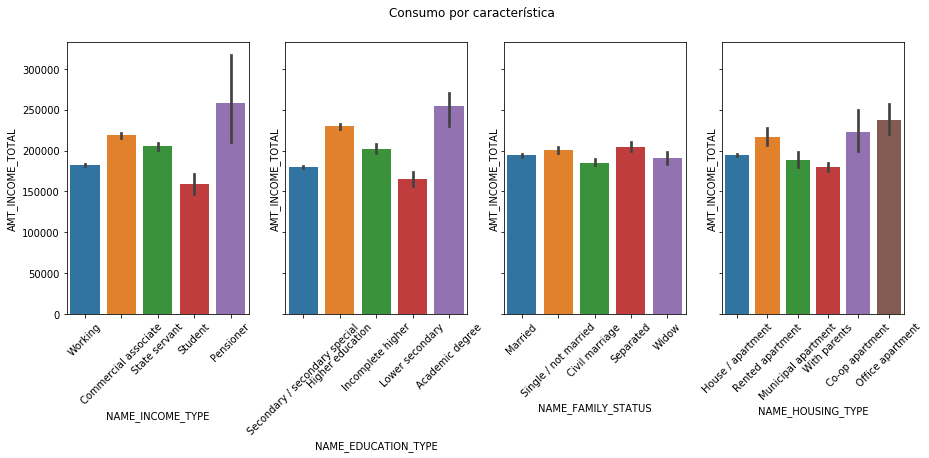

In [41]:
#### Vamos ver como são os níveis de consumo por categorias sociais


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Consumo por característica')

# Bulbasaur
g1 = sns.barplot(ax=axes[0], x=df3.NAME_INCOME_TYPE, y=df3.AMT_INCOME_TOTAL)
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)


# Charmander
g2 = sns.barplot(ax=axes[1], x=df3.NAME_EDUCATION_TYPE, y=df3.AMT_INCOME_TOTAL)
g2.set_xticklabels(g2.get_xticklabels(), rotation=45)

# Squirtle
g3 = sns.barplot(ax=axes[2], x=df3.NAME_FAMILY_STATUS, y=df3.AMT_INCOME_TOTAL)
g3.set_xticklabels(g3.get_xticklabels(), rotation=45)

#
g4 = sns.barplot(ax=axes[3], x=df3.NAME_HOUSING_TYPE, y=df3.AMT_INCOME_TOTAL)
g4.set_xticklabels(g4.get_xticklabels(), rotation=45)



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

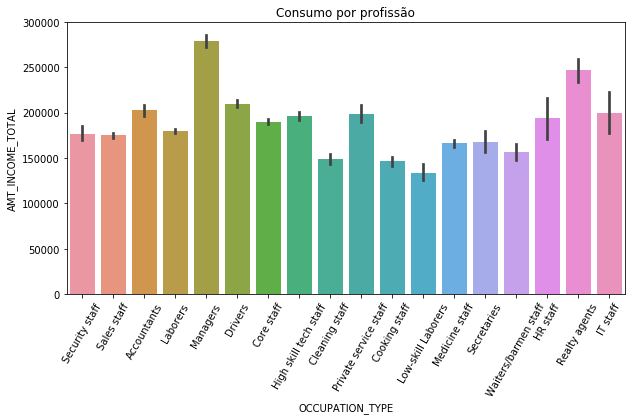

In [42]:

###criando UM catplot individual para a variavel OCCUPATION_TYPE em relação ao poder de compra AMT_INCOME_TOTAL
plt.figure(figsize =(10,5))
ax = sns.barplot(x="OCCUPATION_TYPE", y="AMT_INCOME_TOTAL",data=df3).set_title('Consumo por profissão')
plt.xticks(rotation=60)

### Como há várias categorias, dividiremos todas elas pelo poder de consumo

In [43]:
#média de consumo por profissão
df4 = df3.groupby(['OCCUPATION_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df4['AMT_INCOME_TOTAL']

OCCUPATION_TYPE
Managers                 279117.292829
Realty agents            247500.000000
Drivers                  209797.240412
Accountants              202463.865834
IT staff                 199860.000000
Private service staff    198863.372093
High skill tech staff    196053.579176
HR staff                 193764.705882
Core staff               190172.786967
Laborers                 179794.282402
Security staff           177037.753378
Sales staff              174984.897848
Secretaries              168079.470199
Medicine staff           166114.618061
Waiters/barmen staff     156206.896552
Cleaning staff           149141.107078
Cooking staff            146517.251908
Low-skill Laborers       133920.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [44]:


# Como temos 18 profissões, vamos criar um indice de impacto de 6 níveis, de acordo com o poder de consumo
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Managers','Realty agents'],6)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Drivers','Accountants','IT staff','Private service staff'],5)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['High skill tech staff','HR staff','Core staff','Laborers'],4)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Security staff','Sales staff','Secretaries','Medicine staff'],3)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Drivers','Accountants','IT staff','Private service staff'],2)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Waiters/barmen staff','Cleaning staff','Cooking staff','Low-skill Laborers'],1)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].apply(pd.to_numeric)

In [45]:
# Fazendo o mesmo para educação
df5 = df3.groupby(['NAME_EDUCATION_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df5['AMT_INCOME_TOTAL']

NAME_EDUCATION_TYPE
Academic degree                  253928.571429
Higher education                 229514.648345
Incomplete higher                202280.664653
Secondary / secondary special    179955.714570
Lower secondary                  165455.614973
Name: AMT_INCOME_TOTAL, dtype: float64

In [46]:
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Academic degree'],5)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Higher education'],4)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Incomplete higher'],3)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Secondary / secondary special'],2)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Lower secondary'],1)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].apply(pd.to_numeric)
print(df3['NAME_EDUCATION_TYPE'].unique())

[2 4 3 1 5]


In [47]:
# Fazendo o mesmo para finalidade de uso do crédito
df6 = df3.groupby(['NAME_INCOME_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df6['AMT_INCOME_TOTAL']


NAME_INCOME_TYPE
Pensioner               257538.461538
Commercial associate    218450.592669
State servant           205066.709889
Working                 182547.168800
Student                 159300.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [48]:
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Pensioner'],5)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Commercial associate'],4)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['State servant'],3)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Working'],2)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Student'],1)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].apply(pd.to_numeric)
print(df3['NAME_INCOME_TYPE'].unique())

[2 4 3 1 5]


In [49]:
# Fazendo o mesmo para finalidade de uso do crédito
df7 = df3.groupby(['NAME_HOUSING_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df7['AMT_INCOME_TOTAL']

NAME_HOUSING_TYPE
Office apartment       237812.562814
Co-op apartment        222868.421053
Rented apartment       216431.825740
House / apartment      195017.475251
Municipal apartment    188764.470443
With parents           179850.883217
Name: AMT_INCOME_TOTAL, dtype: float64

In [50]:
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Office apartment'],6)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Co-op apartment'],5)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Rented apartment'],4)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['House / apartment'],3)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Municipal apartment'],2)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['With parents'],1)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].apply(pd.to_numeric)
print(df3['NAME_HOUSING_TYPE'].unique())

[3 4 2 1 5 6]


In [51]:
#Como foi visto no gráfico inicial, a variável estado civil não varia muito de consumo de acordo como status,
# portanto vamos remove-lá junto as demais desnecessárias

df3 = df3.drop(columns=['NAME_FAMILY_STATUS'])
df3 = df3.drop(columns=['ID'])
#Vamos tira a variável FLAG_MOBIL , CNT_CHILDREN e FLAG_WORK_PHONE pois também não traz informação relevante
df3 = df3.drop(columns=['FLAG_MOBIL'])
df3 = df3.drop(columns=['FLAG_WORK_PHONE'])
df3 = df3.drop(columns=['CNT_CHILDREN'])
df3 = df3.drop(columns=['FLAG_PHONE'])
df3 = df3.drop(columns=['FLAG_EMAIL'])
df3.head(2)

FLAG_OWN_CAR  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  NAME_INCOME_TYPE  \
0              1                1          112500.0                 2   
30             0                1          270000.0                 4   

    NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                     2                  3      -21474          -1134   
30                    2                  3      -19110          -3051   

    OCCUPATION_TYPE  CNT_FAM_MEMBERS  MONTHS_BALANCE STATUS  
0                 3              2.0               0      C  
30                3              1.0               0      0

#### Agora vamos analisar a variavel target

##### Temos duas categorias de indivíduos: com atrasos de pagamentos, e sem atrasos. Portanto vamos categorizá-los como **inadimplentes e adimplentes**. A decisão de quem é adimplente ou inadimplente é relativo e depende dos interesses internos das instituições, mas para simplificação do modelo fazeremos dessa forma.

Você deve estar se perguntando se não seria interessante estimar uma regressão linear antes de transformar a variável target em dummy. A questão é que as variáveis explicativas precisam ter distribuição normal para obter os melhores estimadores de MQO, o que não acontece no nosso conjunto de dados. Portando levaremos a nossa análise a modelos não linear.

In [52]:
#letras são adimplentes e números inadimplentes
df3['STATUS'] = df3['STATUS'].replace(['C'],0)
df3['STATUS'] = df3['STATUS'].replace(['X'],0)
df3['STATUS'] = df3['STATUS'].apply(pd.to_numeric) 
df3['STATUS'] = np.where(df3['STATUS']<1, 0, 1)
print(df3['STATUS'].unique())


[0 1]


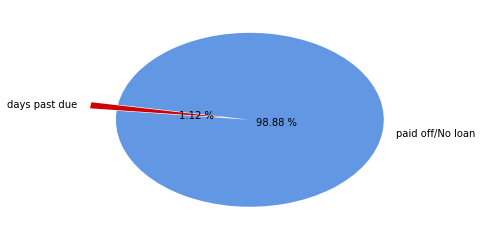

In [53]:
Inadimplente = df3.loc[df3['STATUS'] == 1].count()[0]
Adimplente = df3.loc[df3['STATUS'] == 0].count()[0]

labels = ['days past due', 'paid off/No loan']
colors = ['#d10000', '#6297e3']
explode = (.1,.1)


plt.pie([Inadimplente, Adimplente], labels = labels, colors = colors, 
        autopct = '%.2f %%', pctdistance= 0.2, startangle=170, explode = explode)
plt.show()

Podemos notar que nosso conjunto de dados está **muito desbalanceado** e a proporção de classes é de 24853 Adimplentes para 281 Inadimplentes. E para isso vamos usar o método de resampling para balancear a base de dados.

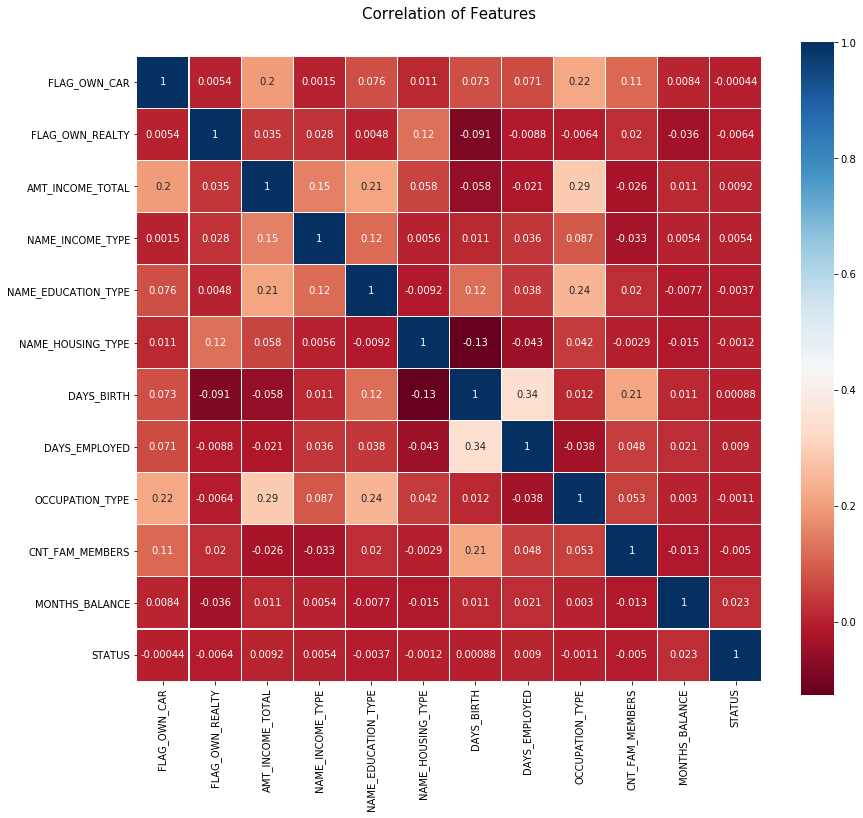

In [56]:
# Chamar a variavel STATUS de risco ajuda a entener melhor
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(df3.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

As variáveis tem poucas correlação entre si, o que pode ser um sinal bom, diminuindo as chances de inflar o modelo.

## Aplicando a técnica de ensemble stacking

In [63]:

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [69]:
# splitting the data

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20,random_state = 1)



In [70]:
#X_res, y_res

In [71]:
#criando uma lista com os modelos
# Vendo qual tem a melhor acurácia para usa-lo no stacking

models = {}
models['knn'] = KNeighborsClassifier()
models['cart'] = DecisionTreeClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['rdm'] = RandomForestClassifier()
models['lgc'] = LogisticRegression(max_iter=1000)
models['ada'] = AdaBoostClassifier()
models['gda'] = GradientBoostingClassifier()

In [72]:
# Voting method
# Método de votação
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    print(name, accuracy)
    
    #Suspeita de overfitting analisar pela curva roc

knn 0.9882633777600954
cart 0.9840859359458922
svm 0.9884623035607718
bayes 0.9876666003580664
rdm 0.9876666003580664
lgc 0.9884623035607718
ada 0.9884623035607718
gda 0.986870897155361


Podemos ver que três modelos estão gerando overfitting, portanto iremos revome-los

In [75]:
# Rodando novamente
models = {}
models['knn'] = KNeighborsClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['lgc'] = LogisticRegression(max_iter=1000)
models['ada'] = AdaBoostClassifier()
models['gda'] = GradientBoostingClassifier()

# Acurácias

# Voting method
# Método de votação
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    print(name, accuracy)

    
    
# Verificando o intervalo de confiança da acurácia
from sklearn.model_selection import cross_val_score    

knn_IC = cross_val_score(models['knn'], x,y, cv=5)
svm_IC = cross_val_score(models['svm'], x,y, cv=5)
bayes_IC = cross_val_score(models['bayes'], x,y, cv=5)
lgc_IC = cross_val_score(models['lgc'], x,y, cv=5)
gda_IC = cross_val_score(models['gda'], x,y, cv=5)
ada_IC = cross_val_score(models['ada'], x,y, cv=5)

scores = {}

scores['knn'] =  knn_IC.mean() + knn_IC.std() * 2, knn_IC.mean() - knn_IC.std() * 2
scores['svm'] =  svm_IC.mean() + svm_IC.std() * 2, svm_IC.mean() - svm_IC.std() * 2
scores['bayes'] =   bayes_IC.mean() + bayes_IC.std() * 2,bayes_IC.mean() - bayes_IC.std() * 2
scores['lgc'] =  lgc_IC.mean() + lgc_IC.std() * 2, lgc_IC.mean() - lgc_IC.std() * 2
scores['gda'] =  gda_IC.mean() + gda_IC.std() * 2, gda_IC.mean() - gda_IC.std() * 2
scores['ada'] =  ada_IC.mean() + ada_IC.std() * 2, ada_IC.mean() - ada_IC.std() * 2

#Cofidence interval 
scores




knn 0.9882633777600954
svm 0.9884623035607718
bayes 0.9876666003580664
lgc 0.9884623035607718
ada 0.9884623035607718
gda 0.986870897155361


{'knn': (0.9888007425049576, 0.9839055294205166),
 'svm': (0.9889786333516483, 0.9886612200749455),
 'bayes': (0.9895360957455704, 0.9859552323798065),
 'lgc': (0.9889786333516483, 0.9886612200749455),
 'gda': (0.9907711523535258, 0.9742957988833724),
 'ada': (0.9889786333516483, 0.9886612200749455)}

In [76]:

#Avaliando o desempenho dos modelos que tiverem a acurácia dentro do intervalo
# para evitar o paradoxo da Acurácia

from sklearn.metrics import classification_report



models = {}

models['knn'] = KNeighborsClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['lgc'] = LogisticRegression(max_iter=1000)
models['ada'] = AdaBoostClassifier()
models['gda'] = GradientBoostingClassifier()


for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    classification = classification_report(y_test,y_pred)
    print(name, classification)

knn               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4969
           1       0.45      0.09      0.14        58

    accuracy                           0.99      5027
   macro avg       0.72      0.54      0.57      5027
weighted avg       0.98      0.99      0.98      5027

svm               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4969
           1       0.00      0.00      0.00        58

    accuracy                           0.99      5027
   macro avg       0.49      0.50      0.50      5027
weighted avg       0.98      0.99      0.98      5027

bayes               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4969
           1       0.00      0.00      0.00        58

    accuracy                           0.99      5027
   macro avg       0.49      0.50      0.50      5027
weighted avg       0.98      0.99      0.98      5027

lgc  

#### Veja como a acurácia pode enganar a escolha do modelo. Os únicos que teveram a capacidade de classificar os indíviduos como possíveis inadimplentes (Recall), foram o KNN, com 18%, beysiano com 4%, Ada com 11%, e o Gda com 18%. Ou seja, do total de inadimplentes existentes na base proposta, apenas 4 modelos coseguiram fazer essa classificação. Todos os demais conseguiram prever apenas os não inadimplentes, que não é o objetivo de análise desse trabalho.

# Qual a importância de analisar o Recall dos modelos nos estudos de crédito?

####   Quando uma empresa crediticia deseja fornecer crédito aos seus clientes, ela não só analisa as acurácias dos modelos. Na verdade isso componhe a menor parte na análise de crédito. Dado as condições internas da instituição, existe sempre um grau de risco nas aplicações de produtos financeiros, e de acordo com a situação interna da empresa, ela determinará qual individuo receberá seu crédito. Portanto, o ponto que mais afeta quem receberá o crédito, é saber qual é a probabilidade de um cliente com determinadas características vir a se tornar um possível inadimplente, e com isso saber qual é a sua probabilidade de ter atrasos, ou não quitação da dívida, e assim determinar o ponto de corte de acordo com o grau de risco que a instituição escolheu. Por exemplo, o banco X não aumentará o limite de cartão de crédito a clientes que possuem probabilidades maior ou igual a 30% de ser inadimplente. Isso equivale a determinar um ponto de corte de 0,3. Ou seja, nas decisões de quem receberá crédito ou não, não é a acurácia que nos traz o melhor desempenho do modelo, mas sim, o seu desempenho quanto a variações nos pontos de cortes, obtido pela AUC da curva ROC que é traçada a partir do Recall.

#### No nosso caso, o único modelo que teve a mínima capacidade classificar os positivos, foi o Beysiano. Vamos obter a AUC para comparar.

In [77]:
from sklearn.metrics import roc_auc_score

model_bayes = GaussianNB().fit(x_train, y_train)
model_ada = AdaBoostClassifier().fit(x_train, y_train)
model_knn = KNeighborsClassifier().fit(x_train, y_train)
model_gda = GradientBoostingClassifier().fit(x_train, y_train)


y_bayes = model_bayes.predict(x_test)
y_ada = model_ada.predict(x_test)
y_knn = model_knn.predict(x_test)
y_gda = model_gda.predict(x_test)

    
auc = {}
auc['bayes'] = roc_auc_score(y_test, y_bayes)
auc['ada'] = roc_auc_score(y_test, y_ada)
auc['knn'] = roc_auc_score(y_test, y_knn)
auc['gda'] = roc_auc_score(y_test, y_gda)

auc


{'bayes': 0.49959750452807405,
 'ada': 0.5,
 'knn': 0.5424997050679732,
 'gda': 0.5076144509753575}

In [ ]:
#Agora vamos interpretar nosso modelo com o Lime (ou Shap)